In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import glob
import random

from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import time

In [2]:
# Declare name of filepath that contains data subfolders

local_directory = 'data/OCT2017'

# Declare other various useful constants

image_types = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
resized_image_dimension = (512, 512)

In [3]:
# Obtain list of all filepaths of images for each directory in the training folder. Save each list of paths
# in 'train_directory_path_lists'

train_directory_path_lists = []
for i_type in image_types:
    train_directory_path_lists.append(glob.glob(local_directory + '/train/' + i_type + '/*'))

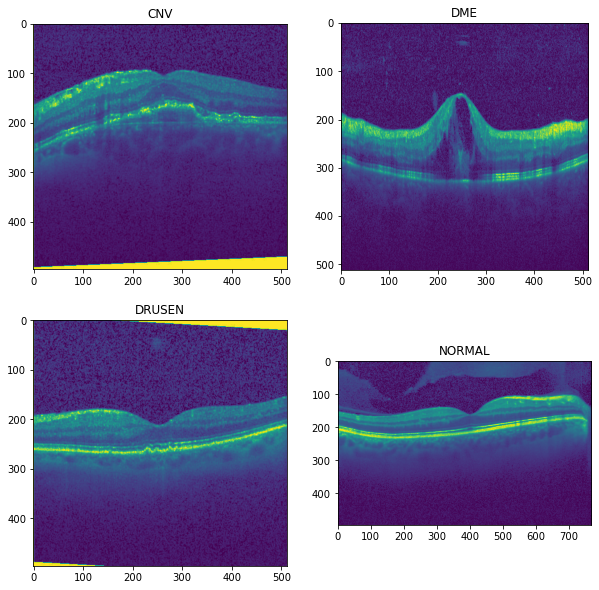

In [4]:
# Plot a random selection of one image from each of the four image types.

fig, axes = plt.subplots(2, 2, figsize= [10, 10])

for i, ax in enumerate(axes.flat):
    img = plt.imread(random.choice(train_directory_path_lists[i]))
    ax.set_title(image_types[i])
    ax.imshow(img)

## NOTES

-> Based on what I've seen from displaying the images we will need to:

    -> Normalize
    
    -> Re-scale (some images contain more pixels than others, this appears to be randomly distributed)
    
    -> Remove yellow cutoffs on the original eye images?
    

In [5]:
def scale_and_normalize(arr):
    """
    Perform Positive Global Standardization on input array and return it.
    Arguments:
        arr: 2-dimensional image array containing int or float values
    Returns:
        arr: positive globally standardized arr of float values
    """
    arr = arr.astype('float32')
    mean, stand_dev = arr.mean(), arr.std()
    arr = (arr-mean)/stand_dev
    arr = np.clip(arr, -1, 1)
    arr = (arr+1)/2
    return arr

In [31]:
# Load images with their respective labels into arrays for training
# Standardize size of all images into 'resized_image_dimension' size (originally (512, 512)),
# convert r4esultant images to grayscale to eliminate RGB color channels, and perform 
# positive global standardization on each of the image arrays. 

X = []
y = []

for i, directory in enumerate(train_directory_path_lists):
    start_time = time.time()
    # Only read one in every one hundred files due to memory constraints
    for j, filepath in enumerate(directory):
        if j % 100 == 0:
            image = cv2.imread(filepath)
            image = cv2.resize(image, resized_image_dimension)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = scale_and_normalize(image)
            X.append(image)
            y.append(i)
    print("Time taken to process " + image_types[i] + " directory :\n\t--- %s seconds ---\n"
          %(time.time() - start_time))

X = np.expand_dims(np.array(X), axis=3)
y = np.array(y)

print(f'Number of examples is: {len(X)}')
print(f'X shape is: {X.shape}')
print(f'y shape is: {y.shape}')

Time taken to process CNV directory :
	--- 1.370542049407959 seconds ---

Time taken to process DME directory :
	--- 0.3688991069793701 seconds ---

Time taken to process DRUSEN directory :
	--- 0.32604002952575684 seconds ---

Time taken to process NORMAL directory :
	--- 0.9560139179229736 seconds ---

Number of examples is: 838
X shape is: (838, 512, 512, 1)
y shape is: (838,)


In [32]:
# Create training and validation sets for model testing, shuffling data 
# (as is the default) prior to forming the two sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [34]:
# Define simple 2d CNN for EDA purposes with a single convolutional layer

model = keras.models.Sequential([
            keras.Input(shape=(512, 512, 1)),
            keras.layers.Conv2D(32, 3, strides=(1, 1), activation='relu',
                                data_format='channels_last', name='conv0'),
            keras.layers.MaxPool2D((2, 2), name='max_pool0'),
            keras.layers.BatchNormalization(name='bn0'),
            keras.layers.Flatten(),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(4, activation='sigmoid')])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 510, 510, 32)      320       
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 255, 255, 32)      0         
_________________________________________________________________
bn0 (BatchNormalization)     (None, 255, 255, 32)      128       
_________________________________________________________________
flatten_2 (Flatten)          (None, 2080800)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                66585632  
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 132       
Total params: 66,586,212
Trainable params: 66,586,148
Non-trainable params: 64
_________________________________________

In [36]:
# Define model optimizer and compile

opt = keras.optimizers.Adam()

model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy'])

In [37]:
# Train model and record iterations

model_iterations = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
21/21 [==============================] - 48s 2s/step - loss: 155.4102 - accuracy: 0.3421 - val_loss: 4.1528 - val_accuracy: 0.3393
Epoch 2/10
21/21 [==============================] - 44s 2s/step - loss: 7.4252 - accuracy: 0.4553 - val_loss: 2.5607 - val_accuracy: 0.4107
Epoch 3/10
21/21 [==============================] - 43s 2s/step - loss: 2.7063 - accuracy: 0.4366 - val_loss: 2.0006 - val_accuracy: 0.4405
Epoch 4/10
21/21 [==============================] - 45s 2s/step - loss: 3.2284 - accuracy: 0.4564 - val_loss: 1.8621 - val_accuracy: 0.4464
Epoch 5/10
21/21 [==============================] - 43s 2s/step - loss: 2.6568 - accuracy: 0.5012 - val_loss: 1.5912 - val_accuracy: 0.4643
Epoch 6/10
21/21 [==============================] - 43s 2s/step - loss: 1.7197 - accuracy: 0.4900 - val_loss: 1.4934 - val_accuracy: 0.4524
Epoch 7/10
21/21 [==============================] - 43s 2s/step - loss: 2.2441 - accuracy: 0.4948 - val_loss: 2.0514 - val_accuracy: 0.4464
Epoch 8/10
21/21 [